In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


Scikit learn provides access to some standard data sets to play around with. One of the most famous ones is called MNIST which contains 70000 images of digits writen by people and they are labelled. It's often called the "hello world" of ML.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets leaded by Scikit generally have the same dict structure
1. DESCR describes the dataset
2. data contains an array with one row per instance and one column per feature
3. target contains an array with the labels

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape


(70000, 784)

In [4]:
y.shape


(70000,)

There are 70k images and each image has 784 features. This is because each image is in a 28x28 pixel format and each feature represents the pixel intensity from 0 to 255 black. Let's look at the first entry in the dataset, reshape it to a 28x28 array and plot it.

In [5]:
28 * 28


784

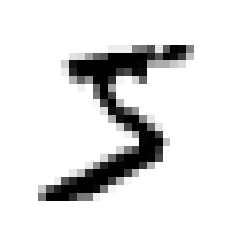

In [6]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()


It looks like a 5 and the label actually tells us it's a 5.

In [7]:
y[0]

'5'

We can notice that the label is a string. We can convert the entire label array to integers


In [8]:
import numpy as np
y = y.astype(np.uint8)


In [9]:
y[0]


5

# Creating a test set before we do anything else

The MNIST dataset is already split into a training set(60k) and a test set(remaining 10k)


In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


The dataset is already shuffled for us which is great because this guarantees that all cross-validation folds will be similar. ML algorithms are also quite sensitive to getting similar instances in a row (like getting a lot of 5s). Shuffling avoids this.


# Training a Binary Classifier

Let's simplify the problem  and only try to identify 1 digit, for exemple the number 5. This classifier will be a binary classifier, capable of distinguishing between just 2 classes: 5 and not-5. As result the labels should be different that the numbers, they should be True for 5s and False for not-5s, let's do that:


In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)


Now let's train a classifier for it. We can use a Stochastic Gradient Descent (SGD) classifier. This class can handle very large datasets well. It's because it deals with training instances independently, one at a time which also makes it good for online learning.


In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(random_state=42)

SGD relies on some randomness so if we want consistent data we should set the random state. Now we can use it


In [13]:
sgd_clf.predict([some_digit])


array([ True])

The classifier guesses that the image is a 5 correctly. Let's check the model's performance


# Performance Measures
## Measuring Accuracy Using Cross-Validation

Sometimes instead of using cross-validation offered by Scikit-Learn we might want to implement it ourselves. This does kind of the same thing as Scikit Learn's cross_val_score():


In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.9669
0.91625
0.96785


Using the scikit learn cross_val_score we get this:

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.95035, 0.96035, 0.9604 ])

That's very good. Above 95% accuracy on every fold. Before we take it for granted let's create a very dumb classifier that puts EVERY SINGLE IMAGE in the "not-5" class:



In [16]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)


This makes a matrix with 1 column and len(X) rows like the output should be. True or False for every instance in the data set. We make a matrix like this with (len(X), 1).
Np.zeros fills a numpy array with 0s. By setting a dtype, it will convert these zero's to that datatype. Setting it to bool means every 0 becomes a False value so the output will actually be an array with 1 column that contains False for every row. Basically it's saying that EVERY instance in the set is not a 5 so it matches with False entries in the labels array.


In [17]:
never_5_clf = Never5Classifier()
never_5_clf.predict(X_train)


array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

So it predicts an array of 60k entries of False. Non of them are a 5. If we use it in a cross val score we get this:

In [18]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.91125, 0.90855, 0.90915])

That's interesting. This very stupid classifier that said everything is NOT a 5 has over 90% accuracy. That's just because a small part of the dataset is actually a 5(like 10%) so always guessing that the image is not a 5 will be correct most of the time.
This shows that accuracy is generally not a good performance measure for classifiers especially when dealing with skewed dataset(when some classes are much more frequent than others)


## Confusion Matrix

A much better way to values performance of a classifier is to use a Confusion matrix. The way it works is counting how many times class A was classified as class B.
Ex: TO find the nr of times the classifier confused images of 5s with 3s we should check the 5th row and the 3rd column of the matrix.

To compute this we need a set of predictions to compare them to the actual targets(labels). We could use the test set but we should keep it untouched and used only at the end.
We could however, use the cross_val_predict() function:


In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

Just like the cross_val_score() it does K-fold cross-folding but instead of giving us the scores, it gives us the predictions made in each fold. This means that we get a clean prediction of each instance in the training set meaning that the prediction of an instance was done by a model that did not see that instance in training. It splits it in 3 and predicts a fold by training a model with the other 2 folds every time.

We can now compute the confusion matrix using the confusion_matrix()


In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)


array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row is an actual class  and each column is a predicted class.
Consider de above table indexes like this: 0 is "non-5s" and 1 is "5s"
The first row is for non-5 images (the negative class). 53892 of non-5 images were CORRECTLY classified as "non-5s" (true negatives TN) but 687 of the "non-5s" were WRONGLY classified as "5s" (false positives FP).
The second row is for 5 images (the positive class). 1891 of the 5 images were WRONGLY classified as "non-5s" (false negatives FN) and 3530 pf the "5s" were CORRECTLY classified as "5s" (true positives TP).

A completely perfect classifiers would only have true positives and true negatives so its confusion matrix would have non-0 values only on it's main diagonal(tep left to bottom right). Let's simulate that


In [21]:
y_train_perfect_predictions = y_train_5 # we pretend we reached perfection in our predictions
confusion_matrix(y_train_5, y_train_perfect_predictions)


array([[54579,     0],
       [    0,  5421]], dtype=int64)

## Precision and Recall

The confusion matrix gives a lot of info but sometimes we need better matrix.

### Precision
Precision is the accuracy of the positive predictions.
precision = TP / (TP + FP)
We can also compute it by using Scikit Learn

In [22]:
from sklearn.metrics import precision_score

precision_score(y_train_5, y_train_pred)


0.8370879772350012

In [23]:
conf_matrix = confusion_matrix(y_train_5, y_train_pred)
conf_matrix[1,1] / (conf_matrix[1,1] + conf_matrix[0,1]) #row, column


0.8370879772350012

### Recall
However, precision might not be enough because we would make 100% accuracy if we make only 1 prediction and make sure it's correct but ignore everything else that should be correct. So we need another metric called recall (or sensitivity or true positive rate TPR).
Recall is the ratio of positive instances that are correctly detected by the classifier:
recall = TP / (TP + FN)
We can also compute it with Scikit Learn

In [24]:
from sklearn.metrics import recall_score

recall_score(y_train_5, y_train_pred)


0.6511713705958311

In [25]:
conf_matrix[1,1] / (conf_matrix[1,1] + conf_matrix[1,0]) #row, column


0.6511713705958311

Our SGD classifier doesn't look just as great now. When it think's an image it's a 5 it's correct 83.7% of the time. In addition, it only detects 65.1% of all the actual 5s.

### F1 Score
It's also often convenient to combine precision and recall into a single metric called the F1 score to compare 2 classifiers. The F1 score is the harmonic mean. A harmonic mean gives much more weight to low values meaning that we would have a good F1 only if both of the values would be high.
F1 = 2 / ((1 / precision) + (1 / recall))
We can use Scikit:


In [26]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)


0.7325171197343846

The F1 score is high for classifiers that have similar precision and recall but that's not always what we want. Sometimes we want higher precision  or sometimes just a higher recall.

For a classifier that detects videos that are safe for kids with a very high precision. You don't want unsafe videos to be classified as safe for kids. However, it's not that terrible to mark safe videos as unsafe(low recall).

On the other hand, for a classifier that detects shoplifters in camera images we want a very high recall. It is very bad for us to NOT detect shoplifters in the images. However, it's not so bad to find shoplifters when there were none. Worst case here is that the security guard will get a few false alerts.

The relationship between precision and recall is such that if we increase precision we reduce recall and vice versa.

## Precision/Recall Trade-off
To understand the trade-off we need to understand how the SGDClassifier makes classifications. For each instance it computes a score based on a decision function. If the score is greater than the threshold it assigns it the positive class. If we order all the instances in the dataset based on the decision function score and we move the threshold to the left we will increase recall and decrease precision but moving it to the right we would increase precision but lower recall.

Scikit does not let us set the threshold of the decision function but it gives us access to the decision scores that it used to make predictions through the decision_function() function.


In [27]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores


array([2164.22030239])

The SGDClassifier uses a threshold of 0 so the found score for some_digit will result in a positive prediction of True

In [28]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

We can raise the threshold

In [29]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred


array([False])

We can see that raising the threshold decreases the recall. The image is a 5 but with a threshold of 8000 the classifier misses it.

So how do we decide what threshold to use. For this let's get the decision function scores for the whole training set.


In [30]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores


array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

With these score we can use precision_recall_curve() to compute the precision and recall for all possible thresholds

In [31]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
print("Precisions", precisions)
print("Recalls", recalls)
print("Thresholds", thresholds)


Precisions [0.09040123 0.09038606 0.09038757 ... 1.         1.         1.        ]
Recalls [1.00000000e+00 9.99815532e-01 9.99815532e-01 ... 3.68935621e-04
 1.84467810e-04 0.00000000e+00]
Thresholds [-106527.45300471 -105763.22240074 -105406.2965229  ...   38871.26391927
   42216.05562787   49441.43765905]


Now we can plot it using Matplotlib

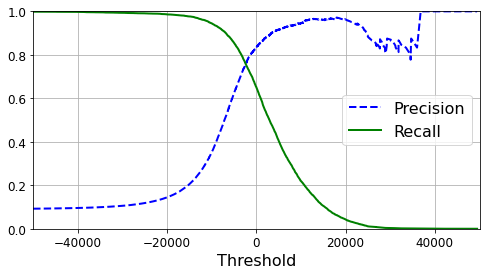

In [32]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])


plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)                                         #
plt.show()


Another way to select a good precision/recall trade-off if to plot precision directly against recall:

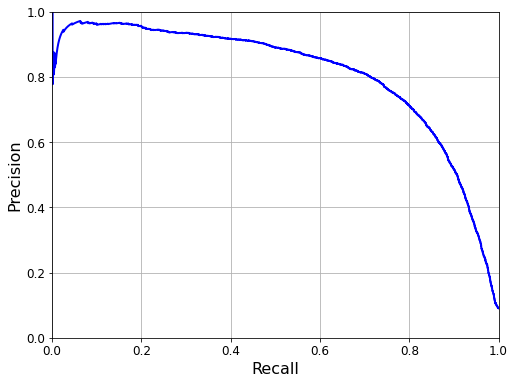

In [33]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()


We can see that precision really start dropping around 80% recall.
So maybe we should select a precision/recall trade-off before that drop. This however  depends on the project.
Let's assume we wish to target 90% accuracy. We can look at the first plot and we can see that for a precision of 90% we would need around 3000-5000 threshold. To compute this value exactly rather than estimate we should search for the lowest threshold that gives at least 90% precision.
np.argmax() will give us the first index of the maximum value which for us is True. So we basically filter the precisions to keep only those above 90% and we use np.argmax to find the index of the first True value then use that index to find the threshold at that index.

In [34]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
threshold_90_precision

3370.0194991439557

We can plot this threshold on the 2 plots from above to see where they intersect the precision and the recall

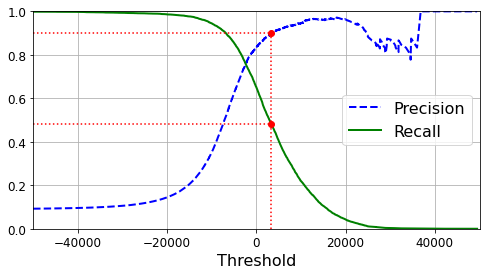

In [35]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()


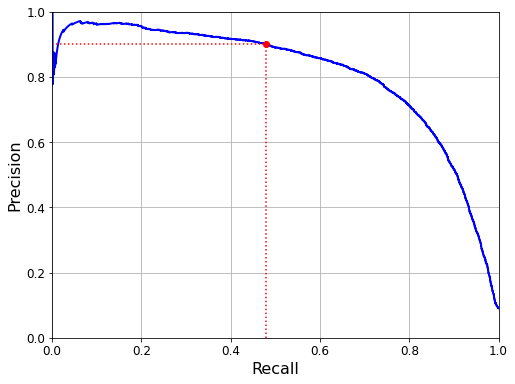

In [36]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()


Now that we know the threshold, to make predictions on the training set we can avoid calling predict again, but rather just setting to true all the scores in list of scores above 90% and false for the rest.

In [37]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90


array([False, False, False, ...,  True, False, False])

It's interesting that the first value that we know is a 5 gets classified as a non-5 because the threshold is higher than it's score. It seems to be quite a bad image of a 5.
So let's check the precision and recall of these predictions.

In [38]:
precision_score(y_train_5, y_train_pred_90)


0.9000345901072293

In [39]:
recall_score(y_train_5, y_train_pred_90)


0.4799852425751706

Awesome! We have a 90% precision classifier. It's quite easy to get the precision that we want. We just raise the threshold enough to get there. A high precision classifier is useless is the recall is too small.
Again, just 1 correct prediction will result in a 100% precision if it's the only one. But it's a very small recall if we should have guesses 1000 correct values instead of only one.
When somebody says "let's get 99% precision" we should ask "at what recall?"

## The ROC Curve
The receiver operating characteristic (ROC) is another common tool used by binary classifiers.
Very similar to the precision/recall curve but instead of plotting precision vs recall, the ROC plots the true positive rate (same as recall) against the false positive rate FPR. The FPR is the ratio of negative instances that are wrongly classified as positive (how many non-5s are wrongly classified as 5s over all non-5s).
It's equal to 1 - the true negative rate TNR which is the ratio of negative instances that are correctly classified as negative (how many non-5s are correctly classified as non-5s over all non 5s). TNR is also called specificity.

As result ROC plots sensitivity(recall) versus 1 - specificity.
First we need to compute the TPE and FPR for various threshold values

In [40]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)


We can not plot the FPR against the TPR using Matplotlib

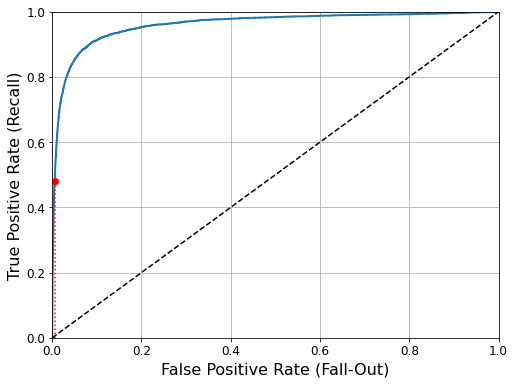

In [41]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")

plt.show()

Again, there is a trade-off. A higher recall means more false positives. The dotted line is a purely random classifier. A very good classifier stays as far away from the dotted line and goes towards the top-left corner.

So, a way to compare classifiers is to measure the area under the curve AUC. A prefect classifier will be equal to 1, while a completely random classifier would be equal to 0.5.
Scikit has a function for this:


In [42]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)


0.9604938554008616

The ROC curve is very similar to the precision/recall curve so when do we use one instead of the other.
Usually we use a PR curve whenever the positive class is rare or when we care about false positives than the false negatives. Otherwise, use a ROC curve. For example the ROC curve for the above classifier looks pretty good actually, but it's mostly because there are few positives compared to the negatives. The PR curve does show that the classifier has room for improvement.

### Training a RandomForestClassifier
Let's train a RandomForestClassifier and compare its ROC curve and  ROC AUC score to those of the SGDClassifier. As we did for the SGDClassifier, we need the decision function scores for each instance.
However, the RandomForestClassifier doesn't have a decision_function method. Instead, it has a predict_proba() method. Scikit classifiers usually one of these methods or both. predict_proba() returns an array containing a row per instance and a column per class, each containing the probability that that instance belongs to the given class (EX: 70% CHANCE THAT THE IMAGE IS A 5)

In [43]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")


The roc_curve function wants labels and scores, but instead of scores we can give it class probabilities so we'll use the positive class's probability as the score

In [44]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)


Now we can plot the roc curve. We'll also include the ROC curve for the SGD classifier to be able to compare:

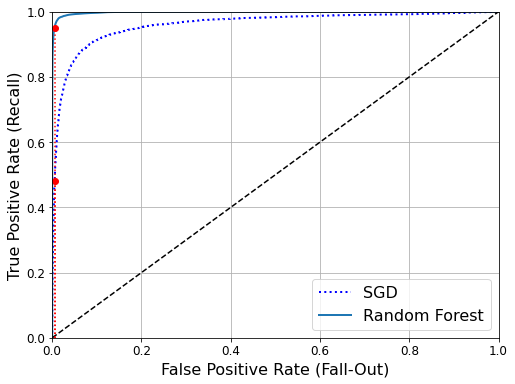

In [45]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()


Wow, the Random Forest Classifier's ROC curve looks much better than the SGD as it goes much closer to the upper left corner. So its ROC AUC should be much better:

In [46]:
roc_auc_score(y_train_5, y_scores_forest)


0.9983436731328145

Holy shit! That's good... Let's check the precision and recall

In [47]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [48]:
recall_score(y_train_5, y_train_pred_forest)


0.8662608374838591

We have a 99% precision and an 86.6% recall.
Now let's detect more than just 5s

# Multiclass Classification